Estudo de caso- simulações de monte carlo e series temporais para modelagem ação Petrobras

importando pacotes

In [246]:
import pandas_datareader as dados
import pandas as pd
import numpy as np
import seaborn as sns
# Imports para cálculos estatísticos
import scipy
#from scipy.stats import kurtosis, skew, shapiro
import warnings
warnings.filterwarnings("ignore")
#formatando valores com duas casas decimais
pd.options.display.float_format = '{:.2f}'.format

plotando dados carregados

Text(0, 0.5, 'Preço de fechamento')

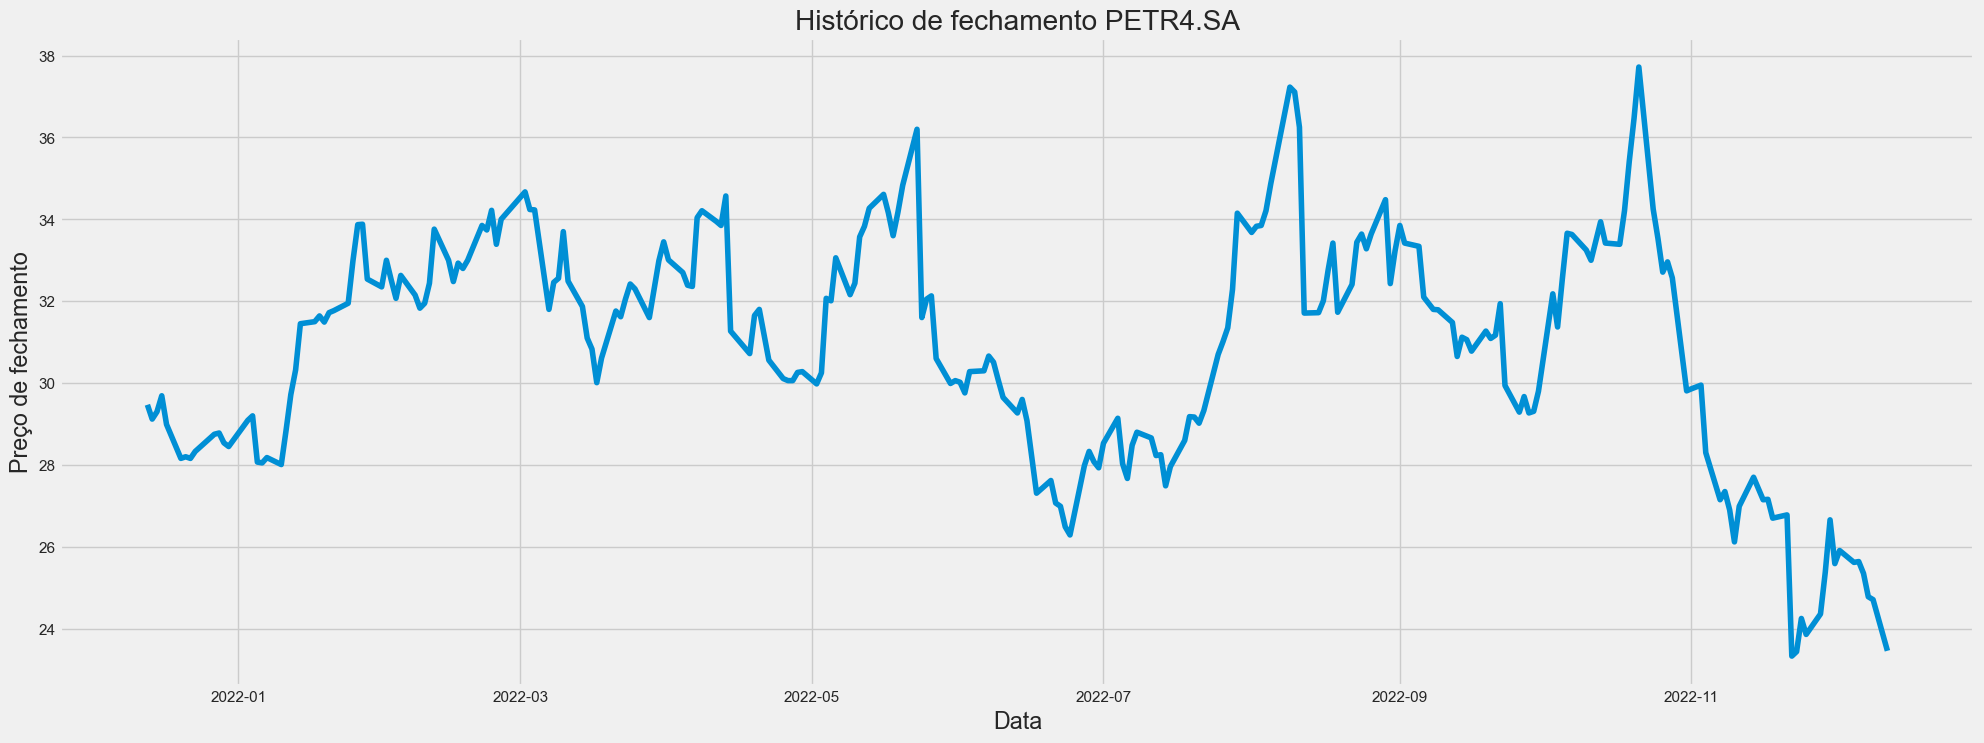

In [247]:
sns.set(rc={'figure.figsize':(18,7)})
ativo = "PETR4.SA"  # https://finance.yahoo.com/
# iremos colocar data inicial, sistema irá buscar até o dia atual
dados_do_ativo = dados.DataReader(ativo, start="2021-12-12", data_source='yahoo')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# plt.style.use('default')
plt.figure(figsize=(22,8))
plt.title('Histórico de fechamento ' + ativo)
plt.plot(dados_do_ativo['Close'])
plt.xlabel('Data')
plt.ylabel('Preço de fechamento')
#plt.show()

In [248]:
dados_do_ativo.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-13,30.05,29.29,29.67,29.47,45448700.00,17.22
2021-12-14,29.85,29.01,29.61,29.12,56833800.00,17.02
2021-12-15,29.30,28.59,29.10,29.30,55085100.00,17.12
2021-12-16,29.98,29.50,29.62,29.69,56545700.00,17.35
2021-12-17,29.64,28.78,29.32,28.99,93593700.00,16.94


In [249]:
# Aqui estamos renomenado as variaveis 
dados_do_ativo.columns = ['Abertura','Maximo','Minimo','Fechamento','Volume','Ajuste_fechamento']
dados_do_ativo.head()

,Abertura,Maximo,Minimo,Fechamento,Volume,Ajuste_fechamento
Date,,,,,,
2021-12-13,30.05,29.29,29.67,29.47,45448700.00,17.22
2021-12-14,29.85,29.01,29.61,29.12,56833800.00,17.02
2021-12-15,29.30,28.59,29.10,29.30,55085100.00,17.12
2021-12-16,29.98,29.50,29.62,29.69,56545700.00,17.35
2021-12-17,29.64,28.78,29.32,28.99,93593700.00,16.94


In [250]:
# Aqui estamos vendo qual a menor e maior dadta dentro da serie 
print('Menor data: ', dados_do_ativo.index.min())
print('Maior data:', dados_do_ativo.index.max())

Menor data:  2021-12-13 00:00:00
Maior data: 2022-12-12 00:00:00


In [251]:
# Vamos observar os dados referente a ultima data do nosso conjunto de dados
# Utilizaremos esses dados mais adiante para compor os parametros a simulação de Monte Carlo
display(dados_do_ativo.loc[dados_do_ativo.index.max()])

Abertura                  24.66
Maximo                    23.13
Minimo                    24.58
Fechamento                23.46
Volume              74196700.00
Ajuste_fechamento         23.46
Name: 2022-12-12 00:00:00, dtype: float64

In [252]:
# Calculando o percentual de mudança na cotação de fechamento diário das ações
# Ou seja, quanto o valor de fechamento varia de um dia para outro, o retorno diário da ação com base no fechamento do dia 
retorno_diario = dados_do_ativo["Fechamento"].pct_change().dropna()
retorno_diario.head

<bound method NDFrame.head of Date
2021-12-14   -0.01
2021-12-15    0.01
2021-12-16    0.01
2021-12-17   -0.02
2021-12-20   -0.03
              ... 
2022-12-06    0.00
2022-12-07   -0.01
2022-12-08   -0.02
2022-12-09   -0.00
2022-12-12   -0.05
Name: Fechamento, Length: 249, dtype: float64>

In [253]:
# Aqui estamos indexando o valor gerado pela variação a nosso conjunto de dados e mostrando dentro dos nossos dados
dados_do_ativo = pd.merge(dados_do_ativo, retorno_diario, how = 'inner', on = 'Date')
dados_do_ativo.columns = ['Abertura','Maximo','Minimo','Fechamento','Volume','Ajuste_fechamento','Variacao_Diaria']
dados_do_ativo.head()

,Abertura,Maximo,Minimo,Fechamento,Volume,Ajuste_fechamento,Variacao_Diaria
Date,,,,,,,
2021-12-14,29.85,29.01,29.61,29.12,56833800.00,17.02,-0.01
2021-12-15,29.30,28.59,29.10,29.30,55085100.00,17.12,0.01
2021-12-16,29.98,29.50,29.62,29.69,56545700.00,17.35,0.01
2021-12-17,29.64,28.78,29.32,28.99,93593700.00,16.94,-0.02
2021-12-20,28.55,27.68,28.44,28.16,106282500.00,16.46,-0.03


In [254]:
# aqui estamos vendo quais o tipos dos nossos dados 
dados_do_ativo.dtypes

Abertura             float64
Maximo               float64
Minimo               float64
Fechamento           float64
Volume               float64
Ajuste_fechamento    float64
Variacao_Diaria      float64
dtype: object

In [255]:
# quantidade de dados após transformaçõo e limpeza 
dados_do_ativo.shape

(249, 7)

In [256]:
# Sumário estatístico dos dados
dados_do_ativo.describe()

,Abertura,Maximo,Minimo,Fechamento,Volume,Ajuste_fechamento,Variacao_Diaria
count,249.00,249.00,249.00,249.00,249.00,249.00,249.00
mean,31.47,30.40,30.93,30.94,80181015.26,22.28,-0.00
std,2.82,2.77,2.80,2.81,33934156.57,4.00,0.03
min,23.43,22.30,23.00,23.33,28713600.00,16.37,-0.13
25%,29.28,28.54,28.99,29.08,56067400.00,19.22,-0.01
50%,31.98,30.84,31.41,31.50,72785700.00,20.79,0.00
75%,33.66,32.44,32.85,33.00,94745400.00,25.63,0.02
max,38.39,36.85,37.65,37.72,262409400.00,33.00,0.08


In [257]:
# Aqui estamos calculando qual foi o retorno acumulado dentro do período
retorno_diario_acumulado = (1 + retorno_diario).cumprod() - 1
retorno_diario_acumulado.max()

0.2799457787435402

Fazendo uma análise exploratória e estatística dos dados do Ativo

In [258]:
# Média do fechamento diário da cotação das ações
media_retorno_diario = np.mean(retorno_diario)
# Desvio padrão do fechamento diário da cotação das ações
desvio_retorno_diario = np.std(retorno_diario)

In [259]:
# Aqui vamos mostrar Média e desvio padrão calculados anteriormente 
print("Média do Retorno de Fechamento:", media_retorno_diario)
print("Desvio Padrão do Retorno de Fechamento:", desvio_retorno_diario)

Média do Retorno de Fechamento: -0.0004907109802928629
Desvio Padrão do Retorno de Fechamento: 0.02875002781353172


In [260]:
# Média e desvio padrão no ano (considerando 252 dias de operações que são os dias uteis)
print("Retorno Médio Anualizado de Fechamento:", (1 + media_retorno_diario) ** 252 - 1)
print("Desvio Padrão Anualizado de Fechamento:", desvio_retorno_diario*np.sqrt(252))

Retorno Médio Anualizado de Fechamento: -0.1163458424808197
Desvio Padrão Anualizado de Fechamento: 0.45639254268477


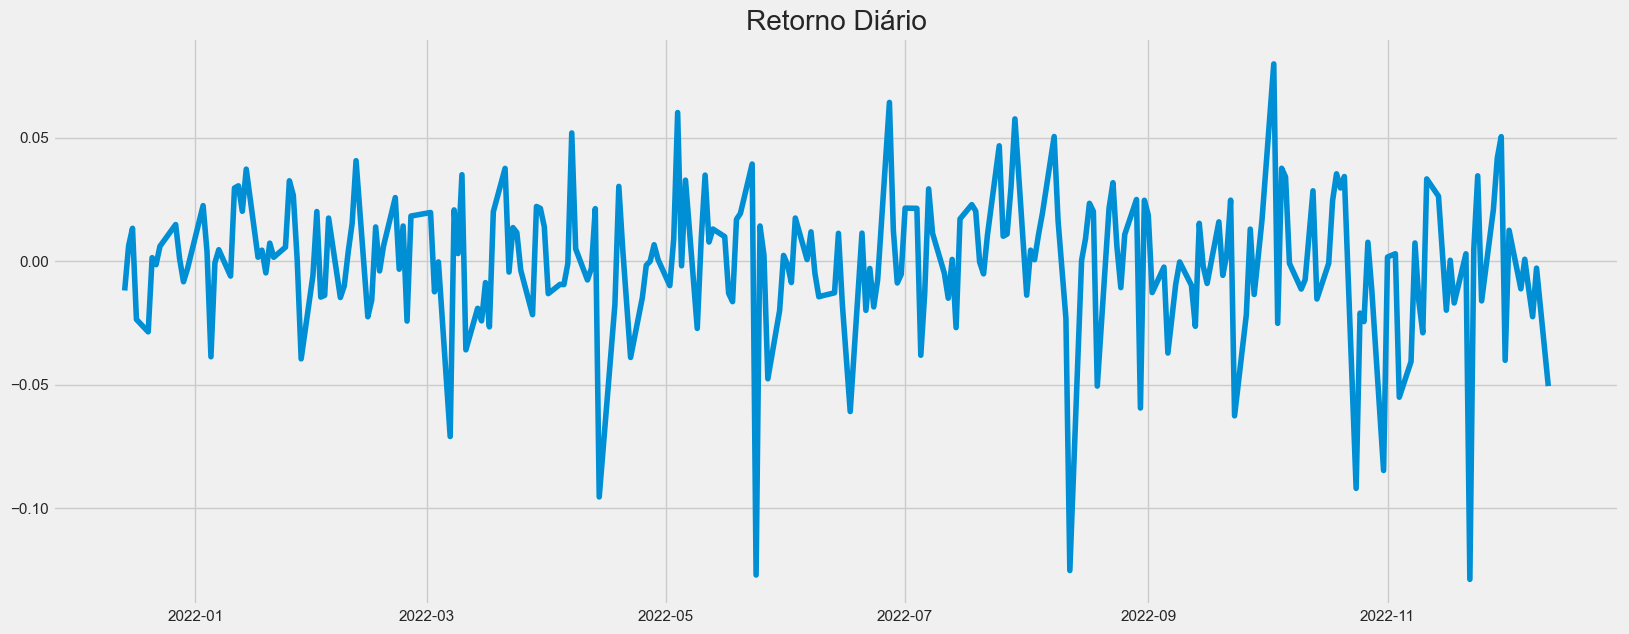

In [261]:
# Plotando grafico com os retornos diários 
# Plot
plt.plot(retorno_diario)
plt.title('Retorno Diário')
plt.show()

Com apenas cinco grandes varioções podemos ver que a variação se manteve constante ao longo do período análisado

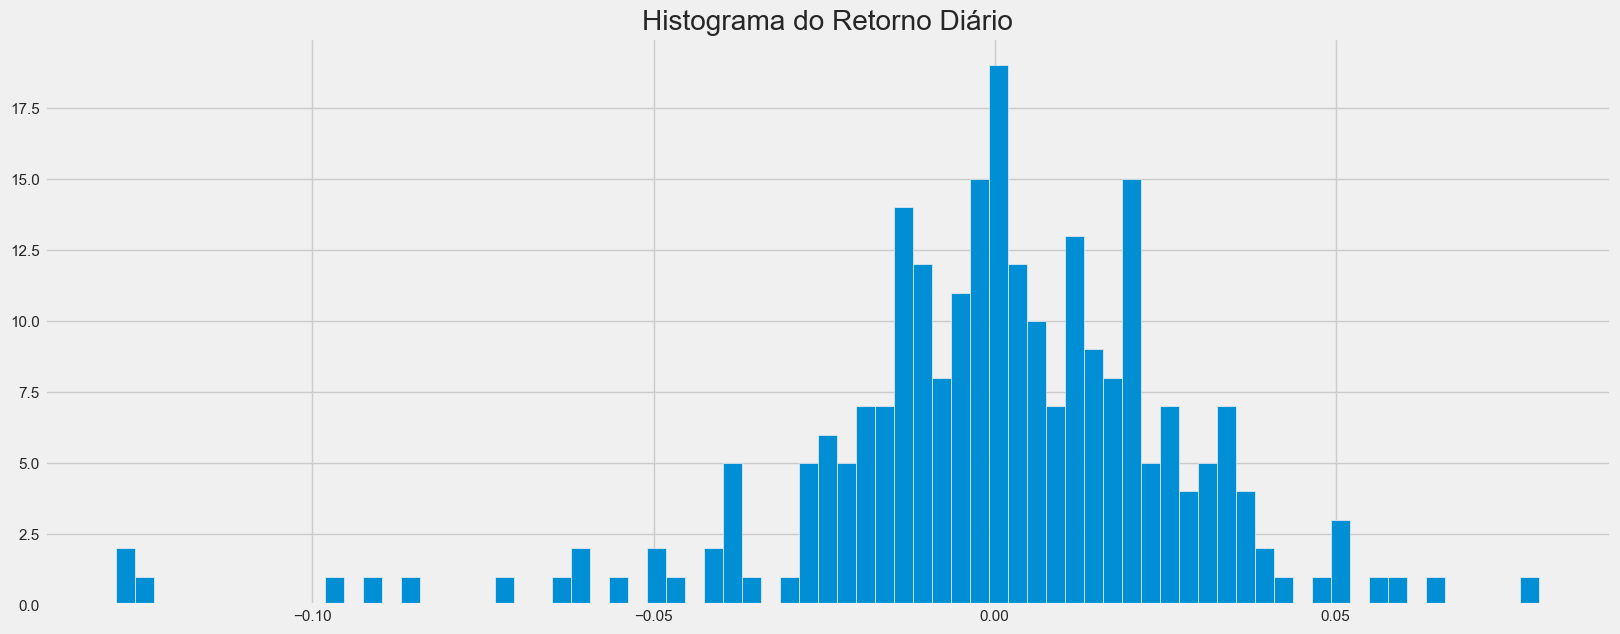

In [262]:
# Plot
plt.hist(retorno_diario,bins = 75)
plt.title("Histograma do Retorno Diário")
plt.show()

Valores estão bem distribuidos em torno da média apesar de haver alguns dados fora da curva, maior parte do tempo se manteve em torno da média

In [263]:
#  a fim de normalizar e suavisar os dados, vamos aplicar uma função de log 
# Transformação de log e diferenciação para cálculo do retorno diário
log_retorno_diario = (np.log(dados_do_ativo["Fechamento"]) - np.log(dados_do_ativo["Fechamento"]).shift(-1)).dropna()

# Calculamos média e desvio padrão após a transformação
log_media_retorno_diario = np.mean(log_retorno_diario)
log_desvio_retorno_diario = np.std(log_retorno_diario)

Após aplicar função log podemos ver uma melhor linearidade nos dados

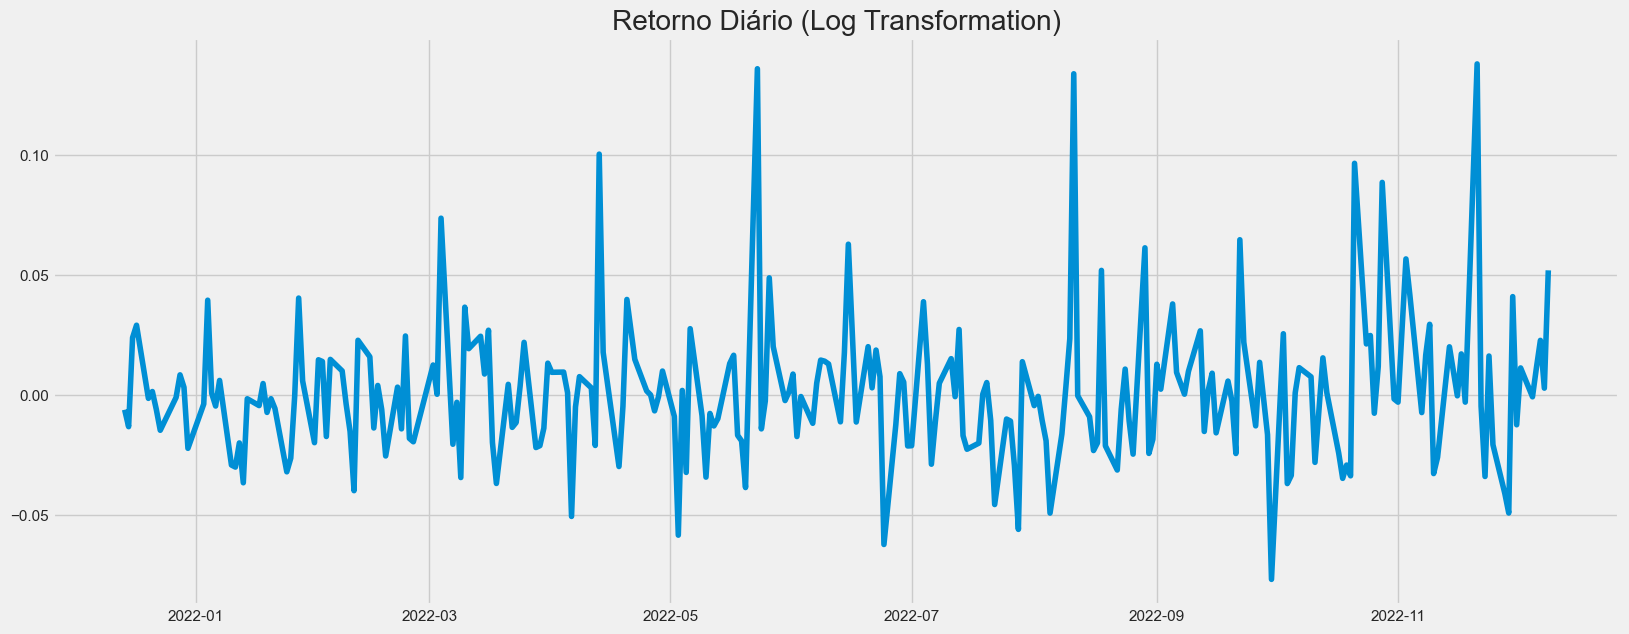

In [264]:
# visualizando dados logaratmizados 
plt.plot(log_retorno_diario)
plt.title("Retorno Diário (Log Transformation)")
plt.show()

Aplicando função log podemos notar uma melhor centralização dos dados

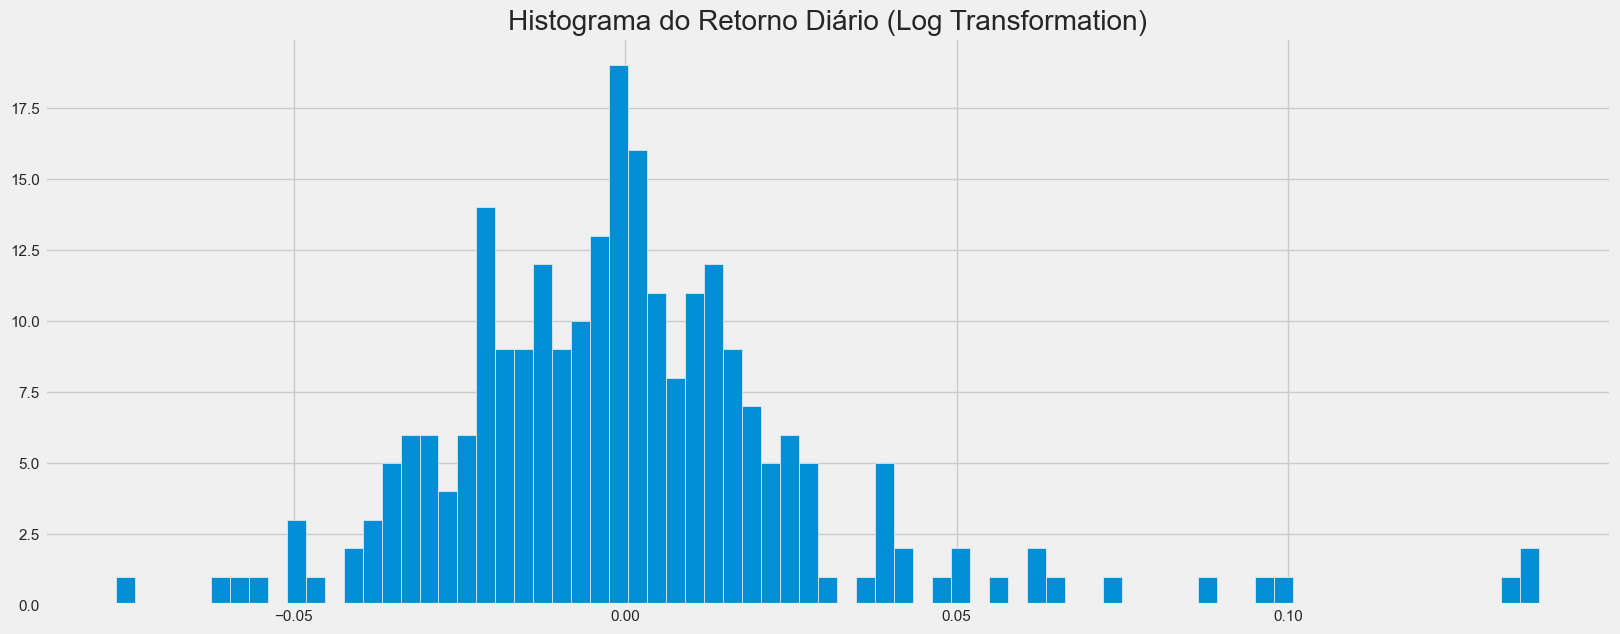

In [265]:
# visualizando histograma verificar de maneira clara distribuição dos dados
plt.hist(log_retorno_diario,bins = 75)
plt.title("Histograma do Retorno Diário (Log Transformation)")
plt.show()

Como tivemos os dados variando em torno de 5% em média vamos contruir noso nivel de variância partindo deste número

In [266]:
# Nível de variância
var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
print("Certeza de que as perdas diárias não excederão o VaR% em um determinado dia com base em valores históricos.")
print("VAR 95%:", var)

Certeza de que as perdas diárias não excederão o VaR% em um determinado dia com base em valores históricos.
VAR 95%: -0.036779575791282236


Aqui vamos determinar em quantos % em média nosso modelo pode errar basedo sempre nos cinco dias, noso modelo vai prever de cinco em cinco dias 

In [267]:
# Var para os próximos 5 dias
var * np.sqrt(5)

-0.0822416316529127

In [268]:
# Nível de variância
var_level = 95
var = np.percentile(log_retorno_diario, 100 - var_level)
cvar = log_retorno_diario[log_retorno_diario < var].mean()
print("Nos piores 5% dos casos, as perdas foram, em média, superiores ao percentual histórico.")
print("CVaR 95%:", cvar)

Nos piores 5% dos casos, as perdas foram, em média, superiores ao percentual histórico.
CVaR 95%: -0.04935124141304454


todo trabalho em analisár dados e cosntruir indicadores nos trouxe até aqui onde vamos realiza a simulação de monte carlo

In [269]:
# Simulação de Monte Carlo

# Número de dias a frente
dias_posteriores = 90

# Número de simulações
simulacoes = 3000

# Último valor da ação
ultimo_preco = 24.71

# Cria um array vazio com as dimensões 
results = np.empty((simulacoes, dias_posteriores))

# Loop por cada simulação
for s in range(simulacoes):
    
    # Calcula o retorno com dados randômicos seguindo uma distribuição normal
    random_returns = 1 + np.random.normal(loc = log_media_retorno_diario, 
                                          scale = log_desvio_retorno_diario, 
                                          size = dias_posteriores)
    
    result = ultimo_preco * (random_returns.cumprod())
    
    results[s, :] = result

In [270]:
# Definindo o índice da série simulada
index = pd.date_range("2022-12-13", periods = dias_posteriores, freq = "D")
resultados = pd.DataFrame(results.T, index = index)
media_resultados = resultados.apply("mean", axis = 1)

resultado simulação monte carlo

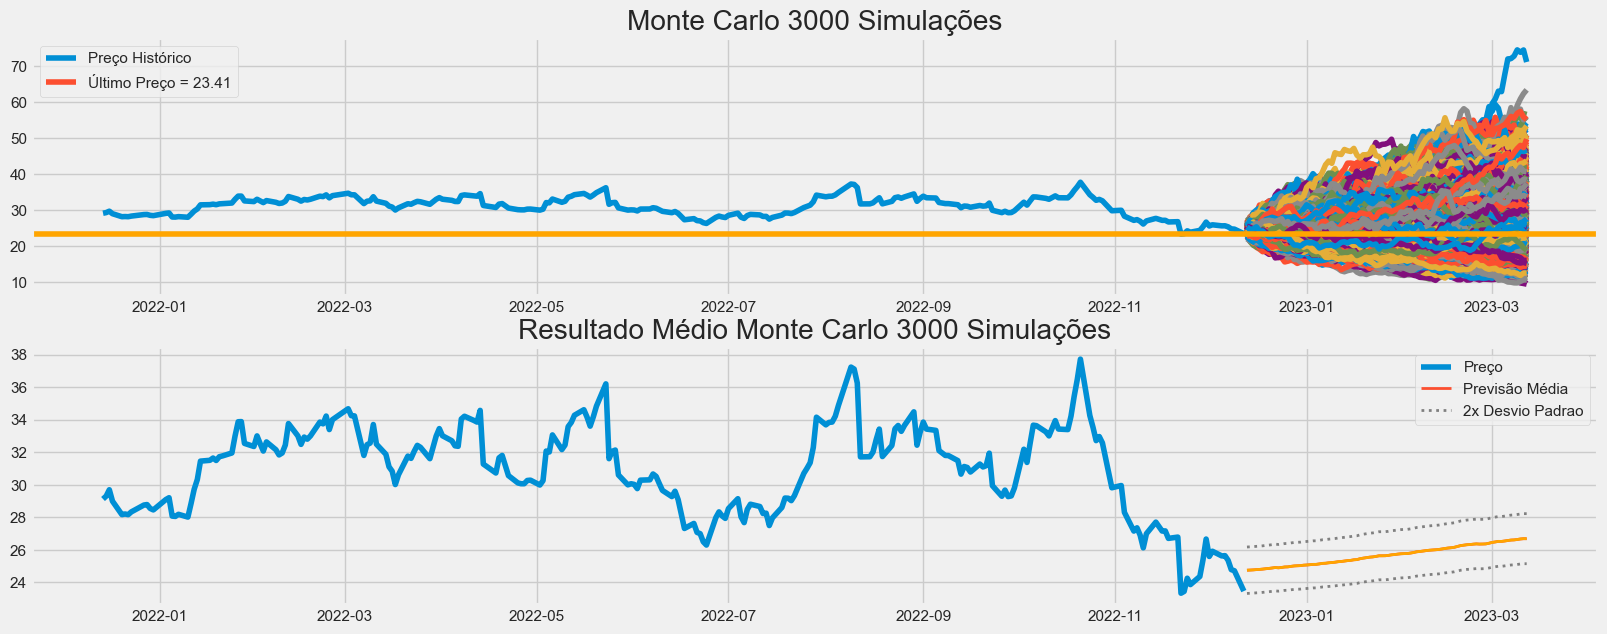

In [273]:
# Dividindo a área de plotagem em 2 subplots

fig, ax = plt.subplots(nrows = 2, ncols = 1)
# Plot
ax[0].plot(dados_do_ativo["Fechamento"][:"2023-03-31"])

ax[0].plot(resultados)

ax[0].axhline(23.46, c = "orange")

ax[0].set_title(f"Monte Carlo {simulacoes} Simulações")

ax[0].legend(["Preço Histórico", "Último Preço = 23.46"])

ax[1].plot(dados_do_ativo["Fechamento"][:"2023-03-31"])

ax[1].plot(resultados.apply("mean", axis = 1), lw = 2)

ax[1].plot(media_resultados.apply((lambda x: x * (1+1.96 * log_desvio_retorno_diario))), 
           lw = 2, linestyle = "dotted", c = "gray")

ax[1].plot(media_resultados, lw = 2, c = "orange")

ax[1].plot(media_resultados.apply((lambda x: x * (1-1.96 * log_desvio_retorno_diario))), 
           lw = 2, linestyle = "dotted", c = "gray")

ax[1].set_title(f"Resultado Médio Monte Carlo {simulacoes} Simulações")

ax[1].legend(["Preço", "Previsão Média", "2x Desvio Padrao"])

plt.show()